<a href="https://colab.research.google.com/github/mertgokcer/MertGokcer/blob/main/MakineOgrenmesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1) Gerekli Kütüphaneler ve Veri Yükleme (Drive’dan)
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

import matplotlib.pyplot as plt

# Drive içindeki dosya yolunuzu buraya yazın:
data_path = '/content/drive/MyDrive/Yükseklisans/Makine Öğrenmesi/HIGGS.csv'

cols = ['label'] + [f'feature_{i}' for i in range(1,29)]
df = pd.read_csv(data_path, header=None, names=cols)



# Örneklem
df = df.sample(n=10000, random_state=42).reset_index(drop=True)

X = df.drop('label', axis=1)
y = df['label']


In [2]:
# 2) Aykırı Değer Analizi (IQR) ve Ölçekleme (MinMax)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X_clipped = X.clip(lower, upper, axis=1)

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_clipped), columns=X.columns)


In [3]:
# 3) Modeller ve Hiperparametre Izgaraları
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'MLP': MLPClassifier(max_iter=200, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

param_grids = {
    'KNN': {'classifier__n_neighbors': list(range(3, 12))},
    'SVM': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']},
    'MLP': {'classifier__hidden_layer_sizes': [(50,), (100,)], 'classifier__activation': ['relu', 'tanh']},
    'XGBoost': {'classifier__n_estimators': [100], 'classifier__max_depth': [3, 5, 7]}
}


In [4]:
# 4) Nested Cross-Validation ile Eğitim ve Değerlendirme
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    pipe = Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=15)),
        ('classifier', model)
    ])
    grid = GridSearchCV(pipe, param_grid=param_grids[name], cv=inner_cv, scoring='roc_auc', n_jobs=-1)

    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_tr, X_te = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        grid.fit(X_tr, y_tr)
        best = grid.best_estimator_

        y_pred = best.predict(X_te)
        y_proba = best.predict_proba(X_te)[:, 1]

        scores['accuracy'].append(accuracy_score(y_te, y_pred))
        scores['precision'].append(precision_score(y_te, y_pred))
        scores['recall'].append(recall_score(y_te, y_pred))
        scores['f1'].append(f1_score(y_te, y_pred))
        scores['roc_auc'].append(roc_auc_score(y_te, y_proba))

    results.append({
        'Model': name,
        'Accuracy': np.mean(scores['accuracy']),
        'Precision': np.mean(scores['precision']),
        'Recall': np.mean(scores['recall']),
        'F1 Score': np.mean(scores['f1']),
        'ROC AUC': np.mean(scores['roc_auc'])
    })

results_df = pd.DataFrame(results).set_index('Model')
print(results_df)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

         Accuracy  Precision    Recall  F1 Score   ROC AUC
Model                                                     
KNN        0.6363   0.636405  0.739384  0.683953  0.672878
SVM        0.6767   0.675317  0.755729  0.713172  0.736120
MLP        0.6821   0.686207  0.743340  0.713095  0.746191
XGBoost    0.6951   0.710301  0.721343  0.715635  0.762793


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:16:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


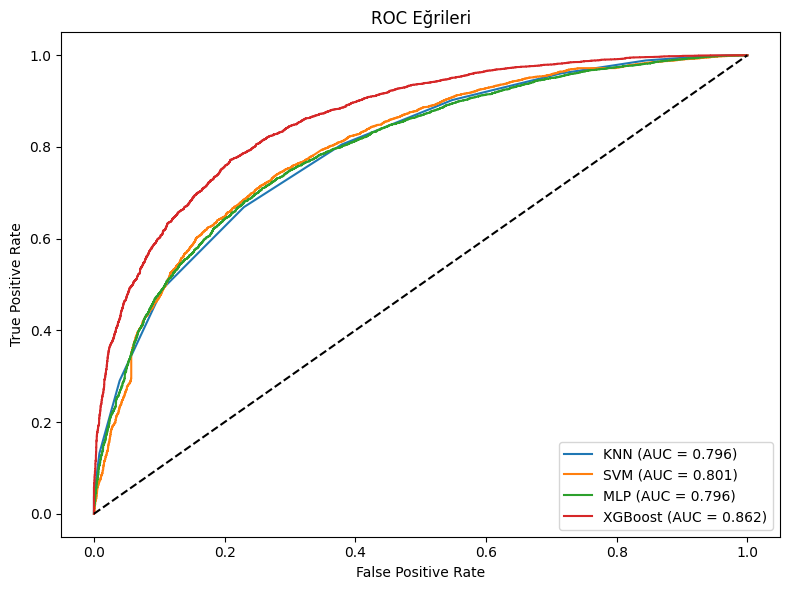

In [5]:
# 5) ROC Eğrilerini Çizme
plt.figure(figsize=(8, 6))

for name, model in models.items():
    pipe = Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=15)),
        ('classifier', model)
    ])
    grid = GridSearchCV(pipe, param_grids[name], cv=inner_cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_scaled, y)
    y_proba = grid.best_estimator_.predict_proba(X_scaled)[:, 1]

    fpr, tpr, _ = roc_curve(y, y_proba)
    auc = roc_auc_score(y, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
